In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

## Load Dataset and Visualization

In [3]:
noisy_moons = datasets.make_moons(n_samples=500, noise=0.11)
X = noisy_moons[0]
y = noisy_moons[1]

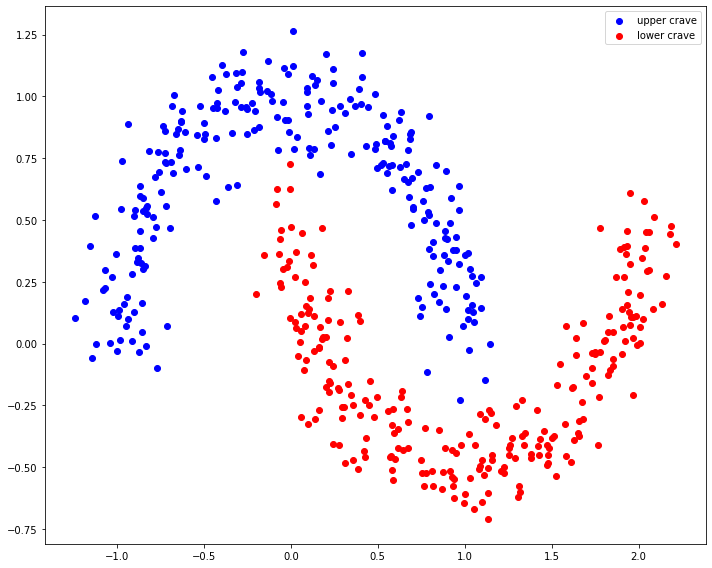

In [4]:
plt.figure(figsize=(10, 8))
plt.scatter(X[y==0, 0], X[y==0, 1], color='blue', label='upper crave')
plt.scatter(X[y==1, 0], X[y==1, 1], color='red', label='lower crave')

plt.legend()

plt.tight_layout()

## Simple Gaussian Estimation


In [5]:
X0 = X[y==0]
mu0 = np.mean(X[y==0], axis=0)
sig0 = np.cov(X[y==0].T)

X1 = X[y==1]
mu1 = np.mean(X[y==1], axis=0)
sig1 = np.cov(X[y==1].T)

In [6]:
def multivariate_normal(mu, sigma, X):
    diff = X - mu[:, np.newaxis]
    det_sigma = np.linalg.det(sigma)
    inv_sigma = np.linalg.inv(sigma)
    g = (np.exp(-(diff.T @ inv_sigma @ diff) / 2)) / (2 * np.pi * np.sqrt(det_sigma))
    return np.diag(g)

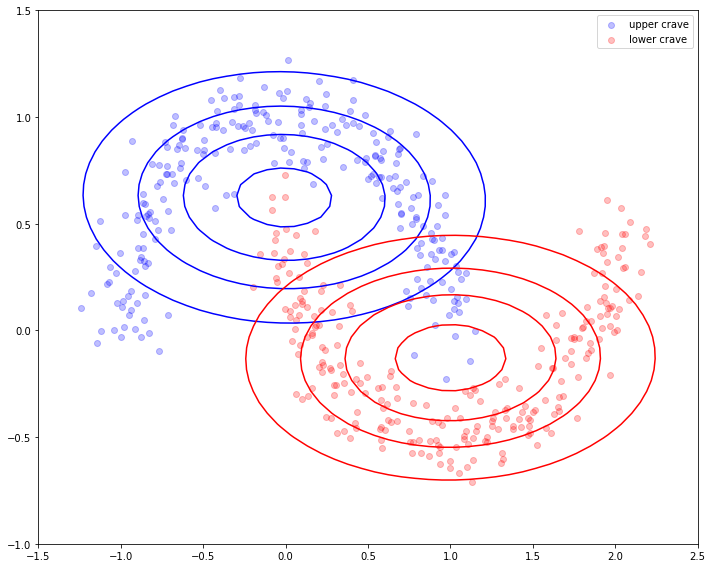

In [7]:
# build meshgrid
X_mesh, Y_mesh = np.meshgrid(np.linspace(-1.5, 2.5), np.linspace(-1, 1.5))
XY_mesh = np.array([X_mesh.ravel(), Y_mesh.ravel()])

plt.figure(figsize=(10, 8))
plt.scatter(X0[:, 0], X0[:, 1], color='blue', label='upper crave', alpha=0.25)
plt.scatter(X1[:, 0], X1[:, 1], color='red', label='lower crave', alpha=0.25)

Z0 = multivariate_normal(mu0, sig0, XY_mesh).reshape(X_mesh.shape)
Z1 = multivariate_normal(mu1, sig1, XY_mesh).reshape(X_mesh.shape)

plt.contour(X_mesh, Y_mesh, Z0, levels=5, colors='blue')
plt.contour(X_mesh, Y_mesh, Z1, levels=5, colors='red')

plt.legend()

plt.tight_layout()

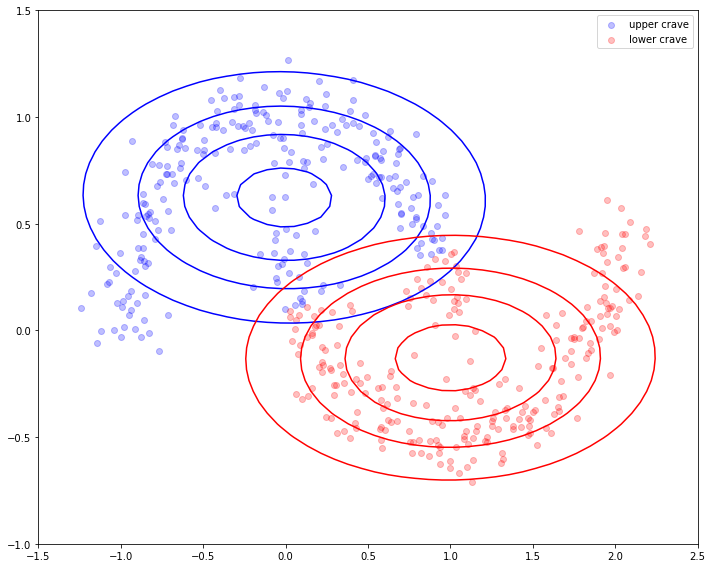

In [8]:
scores = np.array([multivariate_normal(mu0, sig0, X.T), multivariate_normal(mu1, sig1, X.T)])
predict = (scores == scores.max(axis=0)).astype(int)[1]

# build meshgrid
X_mesh, Y_mesh = np.meshgrid(np.linspace(-1.5, 2.5), np.linspace(-1, 1.5))
XY_mesh = np.array([X_mesh.ravel(), Y_mesh.ravel()])

plt.figure(figsize=(10, 8))
plt.scatter(X[predict==0, 0], X[predict==0, 1], color='blue', label='upper crave', alpha=0.25)
plt.scatter(X[predict==1, 0], X[predict==1, 1], color='red', label='lower crave', alpha=0.25)

Z0 = multivariate_normal(mu0, sig0, XY_mesh).reshape(X_mesh.shape)
Z1 = multivariate_normal(mu1, sig1, XY_mesh).reshape(X_mesh.shape)

plt.contour(X_mesh, Y_mesh, Z0, levels=5, colors='blue')
plt.contour(X_mesh, Y_mesh, Z1, levels=5, colors='red')

plt.legend()

plt.tight_layout()

## Build Gaussian Mixture Model

<div dir="rtl">
در این سوال ما توزیع مربوط به هر کلاس را از نوع توزیع گوسی یا ترکیبی از چند توزیع گوسی مختلف در نظر می گیریم که دارای دو پارامتر میانگین و ماتریس کواریانس می باشد
</div>
<br />

$$
N\left(\underline{\mu _{j}} \ ,\ \Sigma _{j}\right) =\frac{1}{( 2\pi )^{\frac{d}{2}} |\Sigma _{j} |^{\frac{1}{2}}}\exp\left( -\frac{1}{2}\left(\underline{x_{i}} -\underline{\mu _{j}}\right)^{T} \Sigma ^{-1}_{j}\left(\underline{x_{i}} -\underline{\mu _{j}}\right)\right)
$$

### Multivariate Gaussian Distribution

In [9]:
def multivariate_normal(mu, sigma, X):
    diff = X - mu[:, np.newaxis]
    det_sigma = np.linalg.det(sigma)
    inv_sigma = np.linalg.inv(sigma)
    g = (np.exp(-(diff.T @ inv_sigma @ diff) / 2)) / (2 * np.pi * np.sqrt(det_sigma))
    return np.diag(g)

### Gaussian Mixture Model

$$
 \begin{array}{l}
p\left(\underline{x_{i}} \ |\ \underline{\theta }\right) \ =\ \sum ^{m}_{j=1} \alpha _{j} \ p_{j}\left(\underline{x_{i}} \ |\ \underline{\theta _{j}}\right) \ ,\ p_{j}\left(\underline{x_{i}} \ |\ \underline{\theta _{j}}\right) \sim N\left(\underline{\mu _{j}} \ ,\ \Sigma _{j}\right) \ ,\ \underline{\theta _{j}} =\left[\underline{\mu _{j}} \ ,\ \Sigma _{j}\right]\\
\underline{\theta } =\left(\underline{\theta _{1}} \ ,\ \underline{\theta _{2}} \ ,\ ...\ ,\ \underline{\theta _{m}} \ ,\ \alpha _{1} \ \ ,\ \alpha _{2} \ \ ,\ ...\ ,\ \alpha _{m} \ \right) \ ,\ \sum ^{m}_{j=1} \alpha _{j} =1
\end{array}
$$
<br />
<div dir="rtl">
برای تخمین زدن پارامتر های مربوط به توزیع مخلوط گوسین باید از روش EM استفاده کنیم
</div>

<div dir="rtl">
روش EM دارای دو بخش اصلی E-step و M-step می باشد که در مرحله ی E-step با توجه به پارامتر های تخمین زده شده در iteration قبلی اقدام به بدست آوردن تابع Q می کنیم و سپس در مرحله ی M-step با بیشینه کردن تابع Q پارامتر های iteration بعدی را بدست می آوریم
</div>
<br />
E-step

$$
 \begin{array}{l}
Q\left(\underline{\theta } \ ,\ \underline{\theta ^{( g)}}\right) =E\left[\log( p( X,\ \underline{y} \ \ |\ \underline{\theta })) \ |\ X\ ,\ \underline{\theta ^{( g)}}\right]\\
=\sum ^{m}_{j=1}\sum ^{n}_{i=1}\log( \alpha _{j}) p\left( j\ |\ \underline{x_{i}} \ ,\ \underline{\theta ^{( g)}}\right) +\sum ^{m}_{j=1}\sum ^{n}_{i=1}\log\left( \ p_{j}\left(\underline{x_{i}} \ |\ \underline{\theta _{j}}\right)\right) p\left( j\ |\ \underline{x_{i}} \ ,\ \underline{\theta ^{( g)}}\right)
\end{array}
$$

M-step

$$
\widehat{\alpha _{j}} =\frac{1}{n}\sum ^{n}_{i=1} p\left( j\ |\ \underline{x_{i}} \ ,\ \underline{\theta ^{( g)}}\right)
$$

$$
\underline{\widehat{\mu _{j}}} =\frac{\sum ^{n}_{i=1} p\left( j\ |\ \underline{x_{i}} \ ,\ \underline{\theta ^{( g)}}\right)\underline{x_{i}}}{\sum ^{n}_{i=1} p\left( j\ |\ \underline{x_{i}} \ ,\ \underline{\theta ^{( g)}}\right)}
$$

$$
\widehat{\Sigma _{j}} =\frac{\sum ^{n}_{i=1}\left(\underline{x_{i}} -\underline{\mu _{j}}\right)^{2} p\left( j\ |\ \underline{x_{i}} \ ,\ \underline{\theta ^{( g)}}\right)}{\sum ^{n}_{i=1} p\left( j\ |\ \underline{x_{i}} \ ,\ \underline{\theta ^{( g)}}\right)}
$$

<br />
<div dir="rtl">
با توجه به اینکه الگوریتم EM یک روش iterative برای تخمین پارامتر می باشد نقطه ی شروع در همگرایی الگوریتم اهمیت دارد در پیاده سازی زیر ما وزن اولیه تمامی component ها را یکسان در نظر گرفته ایم و برای میانگین تعدادی داده را به تصادف انتخاب کرده و آن ها را بعنوان میانگین اولیه component ها در نظر می گیریم و در نهایت ماتریس کواریانس کل داده ها را بعنوان مقدار اولیه ماتریس کواریانس تمامی component ها قرار می دهیم
</div>

In [10]:
class GMM:
    
    def __init__(self, n_components, max_iter=25, reg_covar=1e-6):
        np.random.seed(0)
        self.n_components = n_components
        self.max_iter = int(max_iter)
        self.reg_covar = reg_covar

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.n_features = self.shape
        
        # initialize alpha
        self.alpha = np.full(shape=self.n_components, fill_value=(1/self.n_components))
        
        # initialize component's mu with random data point
        random_row = np.random.randint(low=0, high=self.n, size=self.n_components)
        self.mu = [X[row_index,:] for row_index in random_row]
        
        # initialize sigma
        self.sigma = [np.cov(X.T) for _ in range(self.n_components)]

    def e_step(self, X):
        # E-Step: update weights and alpha holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.alpha = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding alpha and weights constant
        for j in range(self.n_components):
            weight = self.weights[:, j].reshape((self.n, 1))
            total_weight = weight.sum()
            self.mu[j] = (X * weight).sum(axis=0) / total_weight
            self.sigma[j] = np.cov(X.T, aweights=(weight/total_weight).flatten(), bias=True)
            # regularizing covariance matrix to prevent generating sigular matrix
            self.sigma[j].flat[::(self.n_features+1)] += self.reg_covar

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.n_components))
        for j in range(self.n_components):
            likelihood[:, j] = multivariate_normal(self.mu[j], self.sigma[j], X.T)
        
        return (self.alpha * likelihood) / (self.alpha * likelihood).sum(axis=1)[:, np.newaxis]
    
    def score_samples(self, X):
        scores = np.zeros(X.shape[0])
        for i in range(self.n_components):
            scores += self.alpha[i] * multivariate_normal(self.mu[i], self.sigma[i], X.T)
        return scores
    
    def _n_parameters(self):
        """
        Return the number of free parameters in the model.
        """
        cov_params = self.n_components * self.n_features * (self.n_features + 1) / 2.
        mean_params = self.n_features * self.n_components
        return int(cov_params + mean_params + self.n_components - 1)
    
    def aic(self, X):
        """
        Akaike information criterion for the current model on the input X.
        Parameters
        ----------
        X : array of shape (n_samples, n_features)
        Returns
        -------
        aic : float
        The lower the better.
        """
        return -2 * self.score_samples(X).mean() * X.shape[0] + 2 * self._n_parameters()
    
    def bic(self, X):
        """
        Bayesian information criterion for the current model on the input X.
        Parameters
        ----------
        X : array of shape (n_samples, n_features)
        Returns
        -------
        bic : float
        The lower the better.
        """
        return (-2 * self.score_samples(X).mean() * X.shape[0] + self._n_parameters() * np.log(X.shape[0]))
    
    def print_report(self):
        for idx in range(self.n_components):
            print('\u03B1_%d:'%idx)
            print(self.alpha[idx])
            print('\u03BC_%d:'%idx)
            print(self.mu[idx])
            print('\u03A3_%d:'%idx)
            print(self.sigma[idx])
            print()

## Tunning n_components in GMM

/home/mersad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """


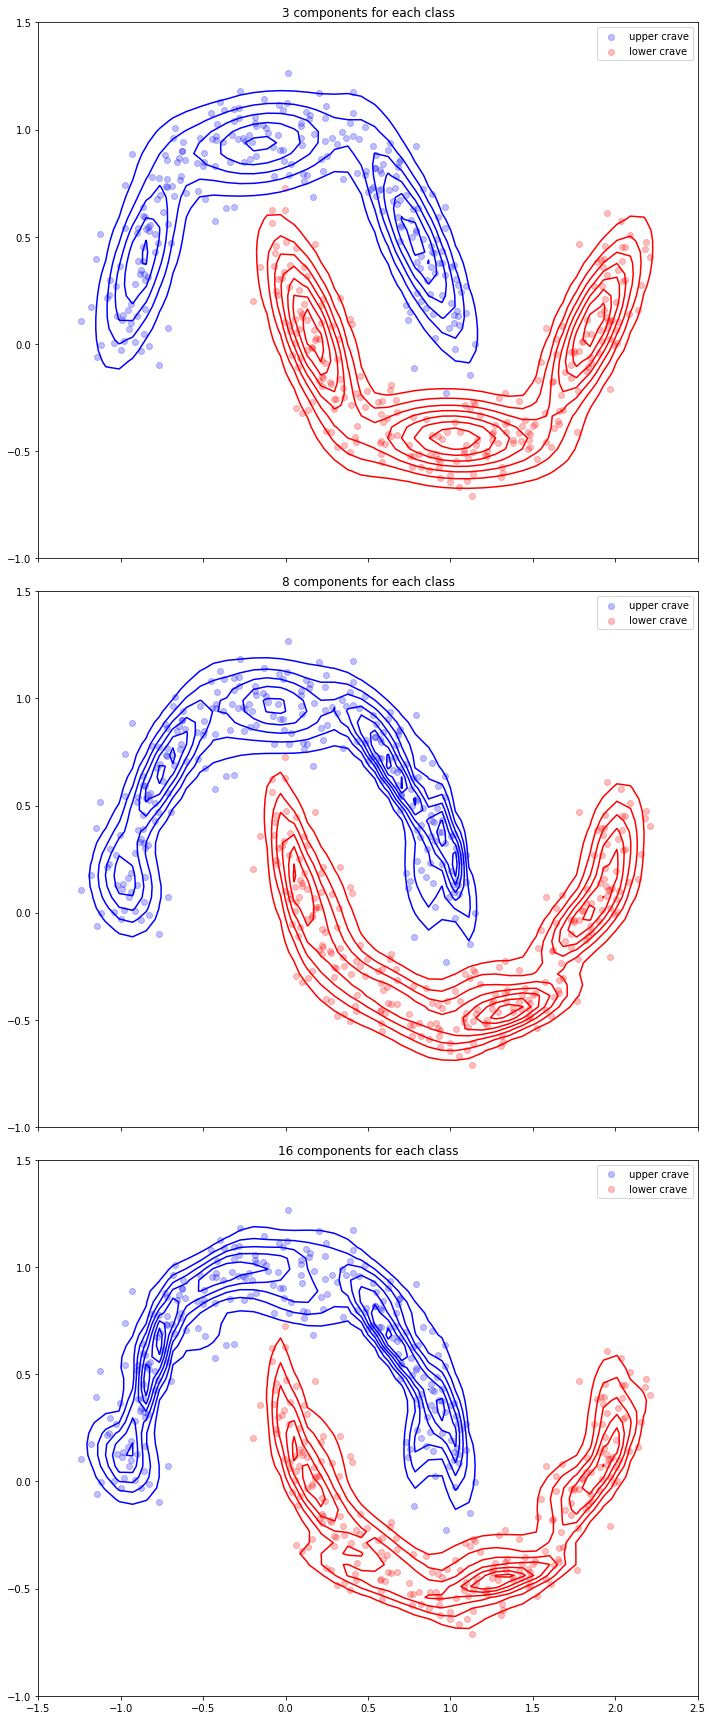

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 24), sharex=True)

# build meshgrid
X_mesh, Y_mesh = np.meshgrid(np.linspace(-1.5, 2.5), np.linspace(-1, 1.5))
XY_mesh = np.array([X_mesh.ravel(), Y_mesh.ravel()]).T

aics0 = []
bics0 = []

aics1 = []
bics1 = []

idx = 0
for nc in range(1, 17):
    gmm0 = GMM(nc)
    gmm0.fit(X0)
    aics0.append(gmm0.aic(X0))
    bics0.append(gmm0.bic(X0))

    gmm1 = GMM(nc)
    gmm1.fit(X1)
    aics1.append(gmm1.aic(X1))
    bics1.append(gmm1.bic(X1))
    
    if nc in (3, 8, 16):
        axs[idx].set_title('%d components for each class' % nc)
        
        axs[idx].scatter(X0[:, 0], X0[:, 1], color='blue', label='upper crave', alpha=0.25)
        axs[idx].scatter(X1[:, 0], X1[:, 1], color='red', label='lower crave', alpha=0.25)

        Z0 = gmm0.score_samples(XY_mesh).reshape(X_mesh.shape)
        axs[idx].contour(X_mesh, Y_mesh, Z0, colors='blue')
        
        Z1 = gmm1.score_samples(XY_mesh).reshape(X_mesh.shape)
        axs[idx].contour(X_mesh, Y_mesh, Z1, colors='red')
        
        axs[idx].legend()
        
        idx += 1
        
plt.tight_layout()

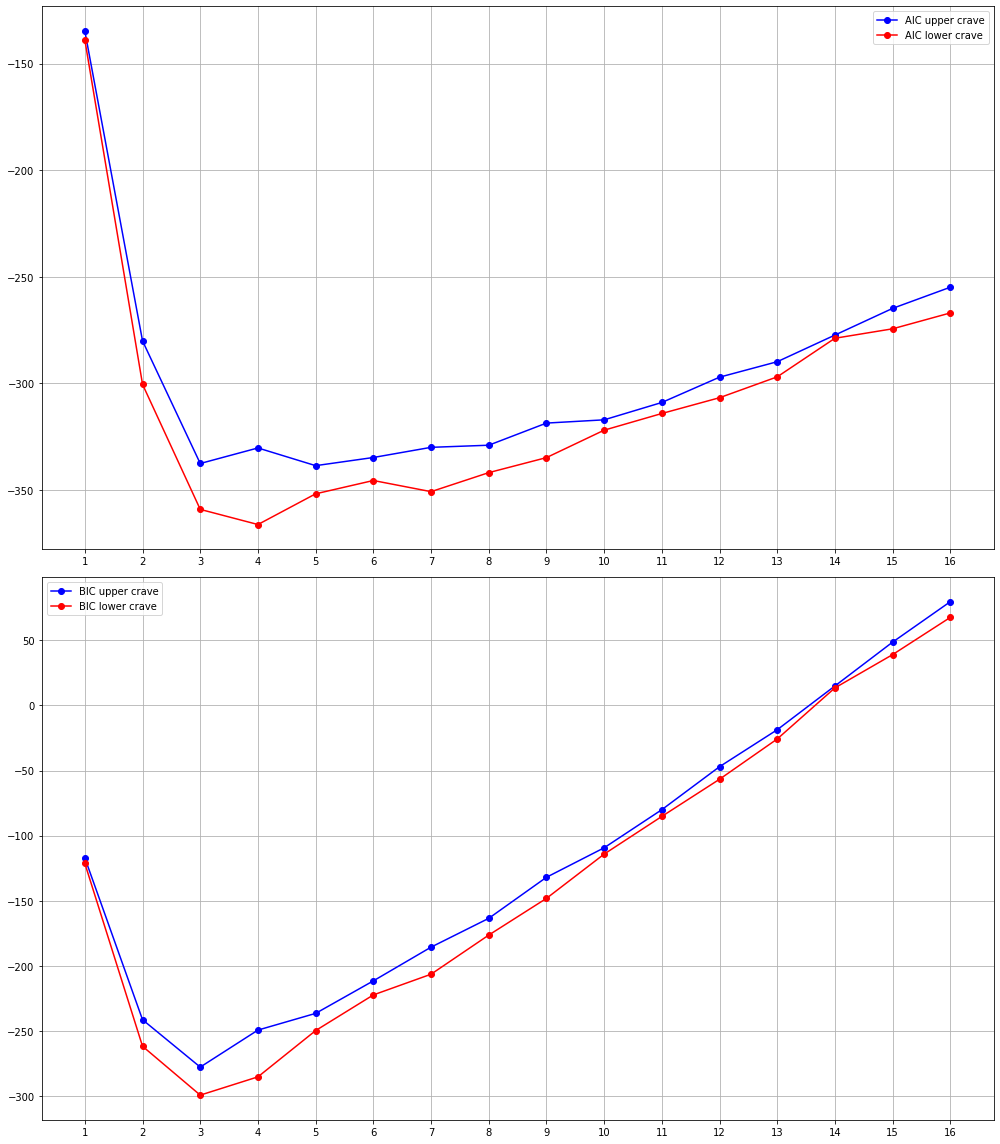

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 16))
ncs = range(1, 17)

axs[0].plot(ncs, aics0, 'bo-', label='AIC upper crave')
axs[0].plot(ncs, aics1, 'ro-', label='AIC lower crave')

axs[0].set_xticks(ncs)
axs[0].grid()
axs[0].legend()

axs[1].plot(ncs, bics0, 'bo-', label='BIC upper crave')
axs[1].plot(ncs, bics1, 'ro-', label='BIC lower crave')

axs[1].set_xticks(ncs)
axs[1].grid()
axs[1].legend()

plt.tight_layout()

## Best Model

Accuracy: 0.994


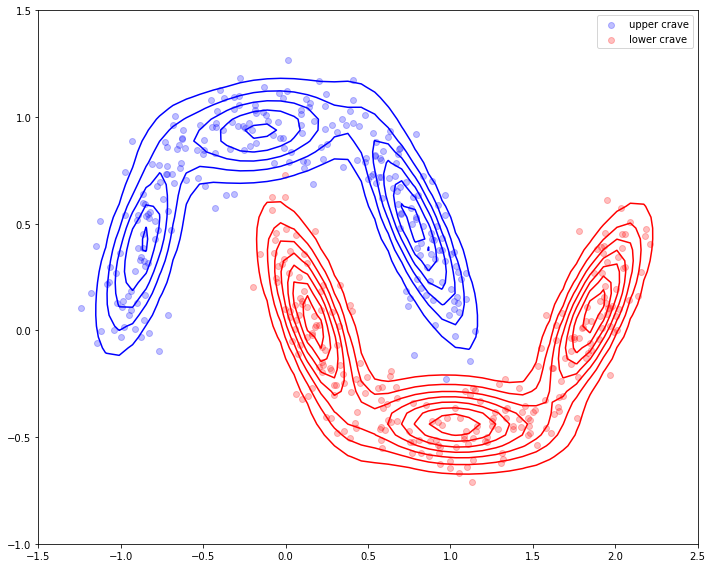

In [13]:
gmm0 = GMM(3)
gmm0.fit(X0)

gmm1 = GMM(3)
gmm1.fit(X1)

scores = np.array([gmm0.score_samples(X), gmm1.score_samples(X)]).T
predict = (scores == scores.max(axis=1, keepdims=1)).astype(int)[:, 1]
accuracy = np.sum(np.equal(predict, y)) / X.shape[0]
print('Accuracy: %.3f' % accuracy)

plt.figure(figsize=(10, 8))
plt.scatter(X0[:, 0], X0[:, 1], color='blue', label='upper crave', alpha=0.25)
plt.scatter(X1[:, 0], X1[:, 1], color='red', label='lower crave', alpha=0.25)

# build meshgrid
X_mesh, Y_mesh = np.meshgrid(np.linspace(-1.5, 2.5), np.linspace(-1, 1.5))
XY_mesh = np.array([X_mesh.ravel(), Y_mesh.ravel()]).T

Z0 = gmm0.score_samples(XY_mesh).reshape(X_mesh.shape)
plt.contour(X_mesh, Y_mesh, Z0, colors='blue')

Z1 = gmm1.score_samples(XY_mesh).reshape(X_mesh.shape)
plt.contour(X_mesh, Y_mesh, Z1, colors='red')

plt.legend()

plt.tight_layout()